# Natural Language Processing with TensorFlow

In [1]:
import tensorflow as tf

# Setup gpu drivers
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

The main goal of natural language processing (NLP) is to derive information from natural language.

* Text
* Speech

> Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)

In [2]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2023-07-09 21:15:09--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4004:80a::2010, 2800:3f0:4004:80b::2010, 2800:3f0:4004:810::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4004:80a::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593,11K   844KB/s    in 0,7s    

2023-07-09 21:15:10 (844 KB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
# Unzip data
unzip_data("nlp_getting_started.zip")

Unzipping `nlp_getting_started.zip` gives the following 3 .csv files:

- `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
- `train.csv` - training samples of real and not real diaster Tweets.
- `test.csv` - testing samples of real and not real diaster Tweets.

### Visualizing a text dataset

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
Remove the http://t.co/9Jxb3rx8mF and Linkury Browser Hijacker http://t.co/B5s5epJ7Um http://t.co/hPA9GQRyWa

---

Target: 0 (not real disaster)
Text:
According to a 2011 Gallup poll the more money you have the more likely you are to suffer from time famine.? AriÛ_ http://t.co/QdmVTJ4lZJ

---

Target: 0 (not real disaster)
Text:
@4Tiles @ZacB_ my dell tablet screams with win10

---

Target: 1 (real disaster)
Text:
The Latest: More homes razed by Northern California wildfire - http://t.co/2nIP3d15dx http://t.co/egYFNlAOQv

---

Target: 0 (not real disaster)
Text:
DK Eyewitness Travel Guide: Denmark: travel guide eBay auctions you should keep an eye on: http://t.co/qPUr3Vd7Hl

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1, # dedicate 10% of samples to validation set
    random_state=42 # random state for reproducibility
)

In [12]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

- **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
    1. **Word-level tokenization**, with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single token.
    2. **Character-level tokenization**, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
    3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.
- **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
    1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
    2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

In [14]:
from tensorflow.keras.layers import TextVectorization

In [15]:
# Use the default TextVectorization variables
text_vectorizer = TextVectorization(
    max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
    standardize="lower_and_strip_punctuation", # how to process text
    split="whitespace", # how to split tokens
    ngrams=None, # create groups of n-words?
    output_mode="int", # how to map tokens to numbers
    output_sequence_length=None, # how long should the output sequence of tokens be?
)

2023-07-09 21:15:10.987070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 21:15:10.987659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [16]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  77, 1776,    5,   85,  653, 1355, 5487,    1,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim=max_vocab_length, # set input shape
    output_dim=128, # set size of embedding vector
    embeddings_initializer="uniform", # default, intialize randomly
    input_length=max_length, # how long is each input
    name="embedding_1"
) 

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
FYI: ;ACCIDENT PROPERTY DAMAGE;3460 LIMESTONE LN;COL;YELLOWSTONE WAY;FIELDSTONE DR;08/05/2015 19:36:35      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02302963,  0.04713346, -0.04361195, ..., -0.02888709,
         -0.00325148, -0.04196633],
        [-0.03687047,  0.01454656, -0.03870597, ..., -0.04347464,
         -0.00051489, -0.04295359],
        [ 0.04344462, -0.00343281,  0.04108752, ..., -0.03313749,
         -0.00628723,  0.01452018],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.02302963,  0.04713346, -0.04361195, -0.01639892, -0.0110131 ,
       -0.04619982,  0.04648959, -0.0437777 , -0.01139256,  0.02103316,
        0.04973144, -0.04313646,  0.01160907, -0.03791947, -0.03483901,
        0.04946733,  0.0015441 ,  0.00566403,  0.02486538,  0.00015681,
        0.03624806, -0.04378878,  0.03039742,  0.01690355, -0.0022974 ,
        0.01481581, -0.01697095,  0.04612421,  0.02441675, -0.01247214,
       -0.03715664,  0.01793149, -0.00878384,  0.0172084 ,  0.01127325,
       -0.01159786, -0.01547537,  0.03706814, -0.02825143,  0.03123552,
       -0.03697674, -0.02677993,  0.03393617, -0.00548829,  0.00784463,
       -0.02412388, -0.04068184, -0.04705523, -0.02094219, -0.02399762,
       -0.02940009,  0.04210461, -0.00632124, -0.04347691, -0.00900681,
       -0.02897203, -0.03138303, -0.01261019, -0.00845705, -0.04783287,
        0.04288604,  0.04916037, -0.01700062,  0.00671352,  0.00769603,
        0.049079

### Modelling a text dataset

- **Model 0**: Naive Bayes (baseline)
- **Model 1**: Feed-forward neural network (dense model)
- **Model 2**: LSTM model
- **Model 3**: GRU model
- **Model 4**: Bidirectional-LSTM model
- **Model 5**: 1D Convolutional Neural Network
- **Model 6**: TensorFlow Hub Pretrained Feature Extractor
- **Model 7**: Same as model 6 with 10% of training data

### Model 0: Baseline

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
    ("clf", MultinomialNB()) # Model the text
])

# fit the pipeline to the training set
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

#### Creating an evaluation function for our model experiments

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(
    y_true=val_labels,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [32]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # Input is 1 dimensional string
x = text_vectorizer(inputs) # Input into numbers
x = embedding(x) # Embedding of the numeric values
x = layers.GlobalAveragePooling1D()(x) # Lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # Output layer, with binary output
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [36]:
# Compile model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [38]:
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="simple_dense_model")
    ]
)

Saving TensorBoard log files to: model_logs/simple_dense_model/20230709-214349
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [39]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 574us/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [40]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073164,  0.01504796, -0.03425452, ..., -0.0440354 ,
         -0.01042278,  0.01876435],
        [ 0.04135865, -0.03945084, -0.03811938, ...,  0.00464736,
          0.03163553,  0.02928305],
        [ 0.00684033,  0.05363134, -0.00241555, ..., -0.07082178,
         -0.04750701,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692342,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018394,  0.0351042 ],
        [-0.0372346 ,  0.06267188, -0.07451146, ..., -0.02367217,
         -0.08643329,  0.01742155]], dtype=float32)>]

In [41]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [42]:
!tensorboard dev upload --logdir ./model_logs \
    --name "First deep model on text data" \
    --description "Trying a dense model with an embedding layer" \
    --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/RJ72DuGBRHKn18KH9YXZSg/

[2023-07-09T21:45:05] Started scanning logdir.
[2023-07-09T21:45:07] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (63.0 kB)
[2023-07-09T21:45:07] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/RJ72DuGBRHKn18KH9YXZSg/


In [43]:
!tensorboard dev delete --experiment_id RJ72DuGBRHKn18KH9YXZSg

Deleted experiment RJ72DuGBRHKn18KH9YXZSg.


In [44]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 470us/step


array([[0.404882  ],
       [0.7443312 ],
       [0.997895  ],
       [0.1089    ],
       [0.1114353 ],
       [0.9355609 ],
       [0.9134594 ],
       [0.99253446],
       [0.9715681 ],
       [0.2657034 ]], dtype=float32)

In [45]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [46]:
# Calculate model_1 metrics
model_1_results = calculate_results(
    y_true=val_labels, 
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [48]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [49]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(
    baseline_results=baseline_results, 
    new_model_results=model_1_results
)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


#### Visualizing learned embeddings

In [50]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [51]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
# Get the weight matrix of embedding layer 
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [53]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
    if num == 0: 
        continue # skip padding token
    vec = embed_weights[num]
    out_m.write(word + "\n") # write words to file
    out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download("embedding_vectors.tsv")
    files.download("embedding_metadata.tsv")

### Recurrent Neural Networks (RNN's)

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

Recurrent neural networks can be used for a number of sequence-based problems:
- **One to one**: one input, one output, such as image classification.
- **One to many**: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
- **Many to one**: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
- **Many to many**: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

### Model 2: LSTM

In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

model_2_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_2"
)


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [55]:
# Compile model
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [56]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [57]:
# Fit model
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        create_tensorboard_callback(SAVE_DIR, "LSTM")
    ]
)

Saving TensorBoard log files to: model_logs/LSTM/20230709-220710
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [58]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.00712613],
        [0.78736913],
        [0.99963766],
        [0.05679176],
        [0.0025822 ],
        [0.9996238 ],
        [0.92170185],
        [0.9997993 ],
        [0.99949545],
        [0.6645746 ]], dtype=float32))

In [59]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calculate LSTM model results
model_2_results = calculate_results(
    y_true=val_labels,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

In [61]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


### Model 3: GRU

In [62]:
tf.random.set_seed(42)

model_3_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_3"
)

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [63]:
# Compile GRU model
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [64]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [65]:
# Fit model
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")]
)

Saving TensorBoard log files to: model_logs/GRU/20230709-221155
Epoch 1/5
215/215 [==============================] - 5s 16ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [66]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.33325186],
        [0.8774119 ],
        [0.9980251 ],
        [0.11561717],
        [0.01235959],
        [0.9925638 ],
        [0.6214276 ],
        [0.9981333 ],
        [0.9982377 ],
        [0.5018121 ]], dtype=float32))

In [67]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calcuate model_3 results
model_3_results = calculate_results(
    y_true=val_labels, 
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

In [69]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bidirectonal RNN model

In [70]:
tf.random.set_seed(42)

model_4_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_4"
)

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [71]:
# Compile
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [72]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [73]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")]
)

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230709-221415
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [74]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.04000106],
       [0.8279268 ],
       [0.99842227],
       [0.13531172],
       [0.00311334],
       [0.99220747],
       [0.9552847 ],
       [0.9994564 ],
       [0.99898285],
       [0.28141788]], dtype=float32)

In [75]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [77]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Convolutional Neural Networks for Text

### Model 5: Conv1D

In [78]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [79]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02534915, -0.03109056,  0.00285618, ..., -0.00783163,
          -0.02685576, -0.04434135],
         [-0.0658626 ,  0.09451497, -0.01477603, ..., -0.00657783,
          -0.0423879 ,  0.07777893],
         [-0.04803649, -0.00709754, -0.02330892, ..., -0.01807335,
           0.02351036,  0.02676385],
         ...,
         [ 0.00073164,  0.01504796, -0.03425452, ..., -0.0440354 ,
          -0.01042278,  0.01876435],
         [ 0.00073164,  0.01504796, -0.03425452, ..., -0.0440354 ,
          -0.01042278,  0.01876435],
         [ 0.00073164,  0.01504796, -0.03425452, ..., -0.0440354 ,
          -0.01042278,  0.01876435]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08324983, 0.00648711, 0.        , 0.03983572, 0.        ,
          0.01144424, 0.00416248, 0.02288384, 0.        , 0.00900974,
          0.        , 0.        , 0.03401766, 0.06408261, 0.08103721,
          0.00409015, 0.

In [80]:
tf.random.set_seed(42)

model_5_embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_5"
)

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [81]:
# Fit the model
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")]
)

Saving TensorBoard log files to: model_logs/Conv1D/20230709-221710
Epoch 1/5
215/215 [==============================] - 2s 8ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [82]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.22534512],
       [0.7534111 ],
       [0.99956024],
       [0.05562783],
       [0.01449854],
       [0.98585176],
       [0.98418933],
       [0.99758804],
       [0.9986262 ],
       [0.26914346]], dtype=float32)

In [83]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(
    y_true=val_labels, 
    y_pred=model_5_preds
)
model_5_results

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [85]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Using Pretrained Embeddings (transfer learning for NLP)

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [86]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed(
    [sample_sentence, "When you call the universal sentence encoder on a sentence, it turns it into numbers."]
)

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [87]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [88]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[], # shape of inputs coming to our model 
    dtype=tf.string, # data type of inputs coming to the USE layer
    trainable=False, # keep the pretrained weights (we'll create a feature extractor)
    name="USE"
) 

In [89]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer, # take in sentences and then encode them into an embedding
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")]
)

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230709-222156
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [91]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.14443198],
       [0.7271504 ],
       [0.9856655 ],
       [0.19740926],
       [0.73417026],
       [0.6859663 ],
       [0.9808888 ],
       [0.9741102 ],
       [0.91573215],
       [0.08070083]], dtype=float32)

In [92]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [93]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [94]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [95]:
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(
    np.array(train_sentences),
    train_labels,
    test_size=0.1,
    random_state=42
)

# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [96]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [97]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(
    x=train_sentences_10_percent,
    y=train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")]
)

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230709-222435
Epoch 1/5
22/22 [==============================] - 2s 31ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 0s 11ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 13ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [99]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.24043253],
       [0.7683783 ],
       [0.9013718 ],
       [0.2906796 ],
       [0.57149965],
       [0.8356513 ],
       [0.80629426],
       [0.83358157],
       [0.85545665],
       [0.11749935]], dtype=float32)

In [100]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [102]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Comparing the performance of each of our models

In [103]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "simple_dense": model_1_results,
    "lstm": model_2_results,
    "gru": model_3_results,
    "bidirectional": model_4_results,
    "conv1d": model_5_results,
    "tf_hub_sentence_encoder": model_6_results,
    "tf_hub_10_percent_data": model_7_results}
)
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


In [104]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

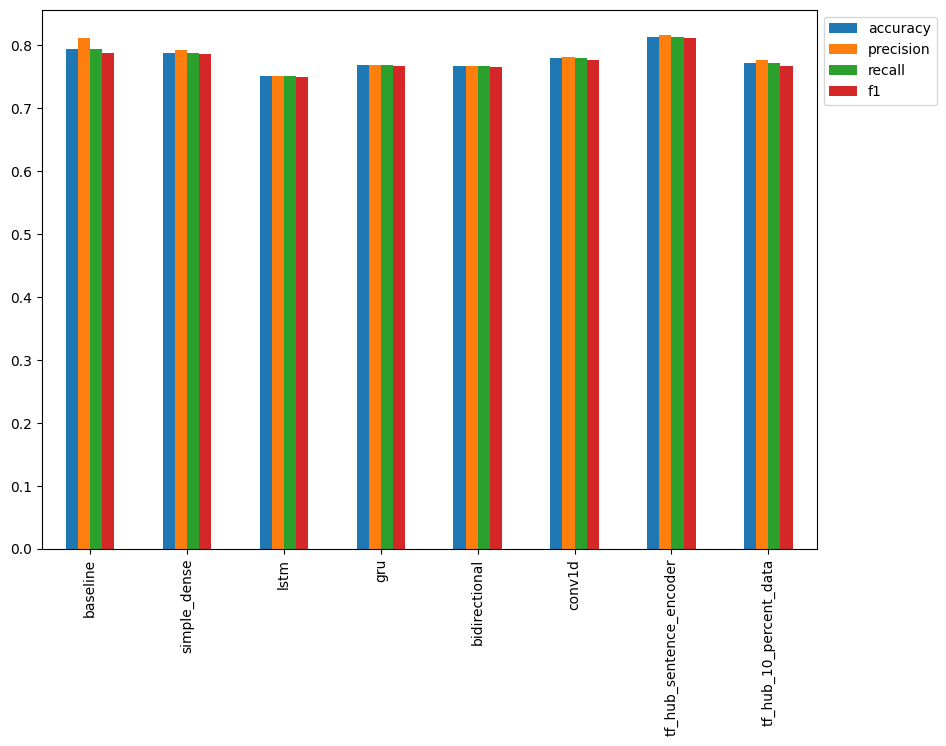

In [105]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

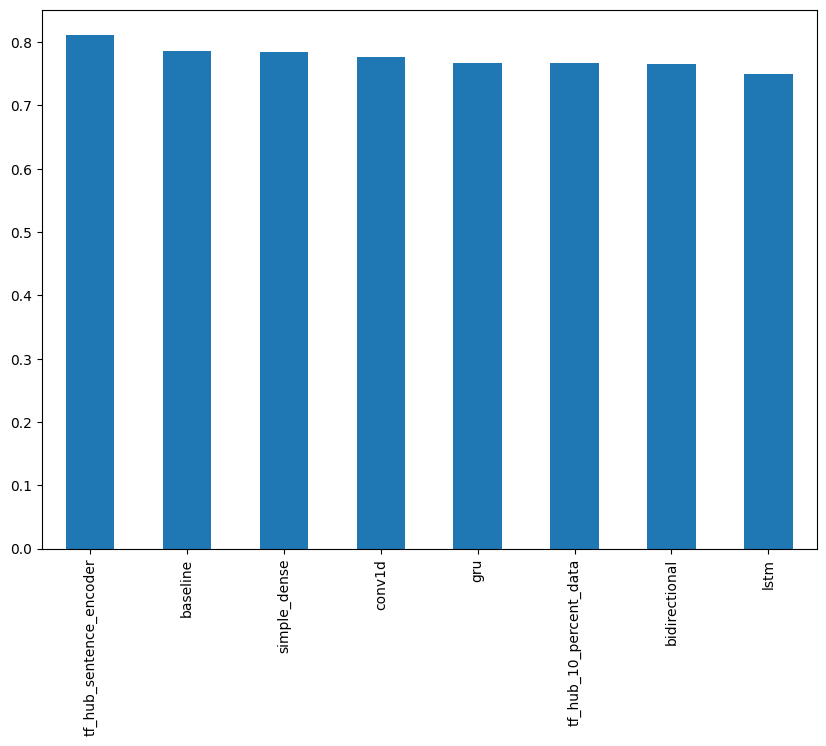

In [106]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [107]:
!tensorboard dev upload --logdir ./model_logs \
    --name "NLP modelling experiments" \
    --description "A series of different NLP modellings experiments with various models" \
    --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/o2ycaFjYREuv5jbDiQAQYw/

[2023-07-09T22:26:41] Started scanning logdir.
[2023-07-09T22:26:50] Total uploaded: 210 scalars, 0 tensors, 7 binary objects (2.7 MB)
[2023-07-09T22:26:50] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/o2ycaFjYREuv5jbDiQAQYw/


In [108]:
!tensorboard dev delete --experiment_id o2ycaFjYREuv5jbDiQAQYw

Deleted experiment o2ycaFjYREuv5jbDiQAQYw.


### Combining our models (model ensembling/stacking)

In [109]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [110]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233,
 'f1': 0.7805169025578647}

In [111]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [112]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

/tmp/ipykernel_134787/3504904892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [113]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.770341,0.775563,0.770341,0.766706
ensemble_results,78.083990,0.780522,0.780840,0.780517


### Saving and loading a trained model

In [114]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [115]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model(
    "model_6.h5", 
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [116]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

In [117]:
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [118]:
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [119]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 8ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

### Finding the most wrong examples

In [120]:
val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_preds,
    "pred_prob": tf.squeeze(model_6_pred_probs)}
)
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985666
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170


In [121]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.837961
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.836361
628,@noah_anyname That's where the concentration c...,0,1.0,0.835225
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834874
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800890
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.782611
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782433
144,The Sound of Arson,0,1.0,0.771343


In [122]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 0, Pred: 1, Prob: 0.910480797290802
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8646755218505859
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8379610180854797
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8363614678382874
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8352250456809998
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8348744511604309
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Pro

In [123]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0, Prob: 0.06304336339235306
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06279503554105759
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06060810387134552
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.057317838072776794
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04535556584596634
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04145139828324318
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03926114737987518
Text:
@SoonerMagic_ I mean I'm a fan but 

### Making predictions on the test dataset

In [125]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 25ms/step
Pred: 1, Prob: 0.6204264163970947
Text:
@JacobHoggard @therealmattleaf  it's so sad out there in BC all the wild fires. Hope u are safe.

----

1/1 [==============================] - 0s 67ms/step
Pred: 1, Prob: 0.9783453941345215
Text:
Two buildings burn in 3-alarm Antioch fire: Two buildings are burning in a 3-alarm fire at the Delta PinesÛ_ http://t.co/GQgF2ygpX2

----

1/1 [==============================] - 0s 92ms/step
Pred: 0, Prob: 0.0986962541937828
Text:
lol at the guy whipping by me on a double yellow line in his mustang just to crash on the curb into a light pole #sns

----

1/1 [==============================] - 0s 59ms/step
Pred: 0, Prob: 0.2502424418926239
Text:
PSA: IÛªm splitting my personalities.

?? techies follow @ablaze_co
?? Burners follow @ablaze

----

1/1 [==============================] - 0s 65ms/step
Pred: 0, Prob: 0.26033467054367065
Text:
Obama 2016? - The Abomination of Desolation' http://t.co/iL4uLhrgTP


### Predicting on Tweets from the wild

In [127]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [128]:
def predict_on_sentence(model, sentence):
    """
    Uses model to make a prediction on sentence.

    Returns the sentence, the predicted label and the prediction probability.
    """
    pred_prob = model.predict([sentence])
    pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
    print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
    print(f"Text:\n{sentence}")

In [129]:
# Make a prediction on Tweet from the wild
predict_on_sentence(
    model=model_6,
    sentence=daniels_tweet
)

1/1 [==============================] - 0s 47ms/step
Pred: 0.0 (not real disaster) Prob: 0.04623398184776306
Text:
Life like an ensemble: take the best choices from others and make your own


In [130]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [131]:
# Predict on diaster Tweet 1
predict_on_sentence(
    model=model_6, 
    sentence=beirut_tweet_1
)

1/1 [==============================] - 0s 24ms/step
Pred: 1.0 (real disaster) Prob: 0.9625465869903564
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [132]:
# Predict on diaster Tweet 2
predict_on_sentence(
    model=model_6, 
    sentence=beirut_tweet_2
)

1/1 [==============================] - 0s 22ms/step
Pred: 1.0 (real disaster) Prob: 0.9678557515144348
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


### The speed/score tradeoff

In [134]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
  
    Args:
    ----
    model = a trained model
    sample = a list of samples

    Returns:
    ----
    total_time = total elapsed time for model to make predictions on samples
    time_per_pred = time in seconds per single sample
    """
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time # calculate how long predictions took to make
    time_per_pred = total_time/len(val_sentences) # find prediction time per sample
    return total_time, time_per_pred

In [135]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.32968926600005943, 0.0004326630787402355)

In [136]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.012554085005831439, 1.6475177173007138e-05)

Text(0, 0.5, 'F1-Score')

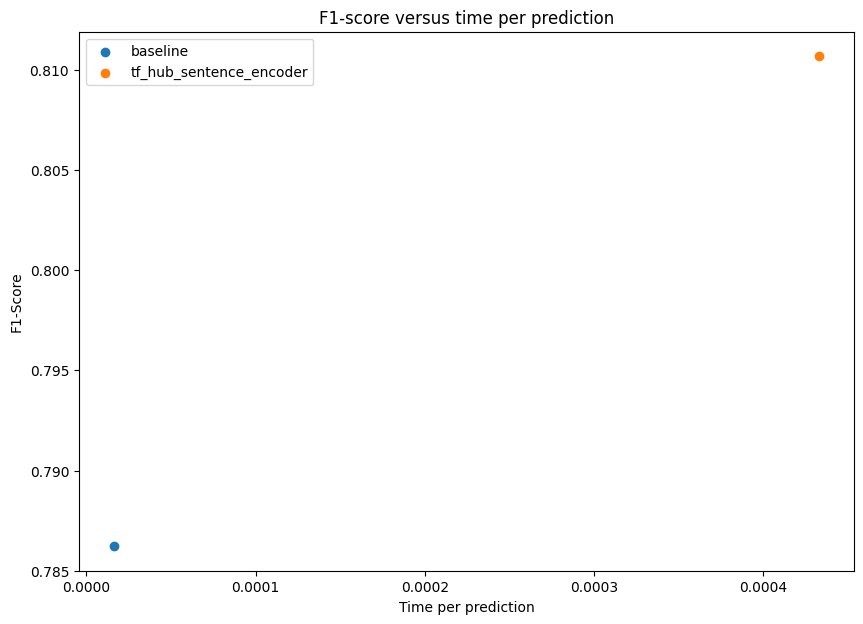

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")